# 09. PyTorch Model Deployment

What is model deployment?
Machine learning model deployment is the act of making your machine learning model(s) available to someone or something

## Resources:
* Book version of notebook: https://www.learnpytorch.io/09_pytorch model deployment/
* Slides: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/slides/09_pytorchmodel deployment.pdf

## 0. Get Setup

In [21]:
import matplotlib.pyplot as plt
import torch
import torchvision

import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from param import output

from torchinfo import summary
from going_modular import data_setup, engine
from helper_functions import download_data, set_seeds, plot_loss_curves

In [71]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## 1. Getting Data

The dataset we're going to use for deploying a FoodVision Mini model is...

Pizza, steak, sushi 20% dataset (pizza, steak, sushi classes from Food101, random 20% of samples)

In [26]:
data_20_percent_path = download_data(
    source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
    destination="pizza_steak_sushi_20_percent")

[INFO] data/pizza_steak_sushi_20_percent directory exists, skipping download.


In [28]:
# Setup training and test paths
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

## 2. FoodVision Mini model deployment experiment outline
### 3 questions:
1. What is my most ideal machine learning model deployment scenario?
2. Where is my model going to go?
3. How is my model going to function?

**FoodVision Mini ideal use case:** A model that performs well and fast

* Performs well: 95%+ accuracy
* Fast: as close to real-time (or faster) as possible.

To try and achieve these goals, we're going to build two model experiments:
1. EffNetB2 feature extractor (just like in 07. PyTorch Experiment Tracking)
2. ViT feature extractor (just like in 08. PyTorch Paper

## 3. Creating an EffNetB2 feature extractor
Feature extractor = a term for a transfer learning model that has its base layers frozen and output layers (or head layers) customized to a certain problem.

EffNetB2 pretrained model in PyTorch -
https://docs.pytorch.org/vision/stable/models/generated/torchvision.models.efficientnet_b2.html#torchvision.models.EfficientNet

In [41]:
import torchvision

# Create an EffNetB2
effnetB2 = torchvision.models.efficientnet_b2(weights="DEFAULT").to(device)

for param in effnetB2.parameters():
    param.requires_grad = False

effnetB2

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [42]:
summary(effnetB2,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [43]:
effnetB2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [45]:
set_seeds()
effnetB2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=1000, bias=True),
)

### 3.1 Creating a function to make an EffNetB2 feature

In [55]:
def create_effnetb2_model(num_classes:int=3,# default output classes = 3 (pizza, steak, sushi)
                          seed:int=42):
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights=weights).to(device)
    transforms = weights.transforms()

    for param in model.parameters():
        param.requires_grad = False

    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=1000, bias=True),
    )

    return model, transforms

In [56]:
effnetB2_model, effnetB2_transforms = create_effnetb2_model()

In [58]:
summary(effnetB2_model,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [63]:
train_dataloader_effnetB2, test_dataloader_effnetB2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               train_transform=effnetB2_transforms,
                                                                               test_transform=effnetB2_transforms,
                                                                               batch_size=32)

In [67]:
len(train_dataloader_effnetB2), len(test_dataloader_effnetB2), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

#3.3 Training EffNetB2 feature extractor

In [72]:
from going_modular import data_setup, engine

# Loss function
loss_fn = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(effnetB2_model.parameters(), lr=0.001)

# Training function (engine.py)
set_seeds()
effnetB2_results = engine.train(
    effnetB2_model,
    train_dataloader_effnetB2,
    test_dataloader_effnetB2,
    optimizer,
    loss_fn,
    10,
    device
)

Epoch: 10 | train_loss: 0.4964 | train_acc: 0.9313 | test_loss: 0.5988 | test_acc: 0.9597


### 3.4 Inspecting EffNetB2 loss curves

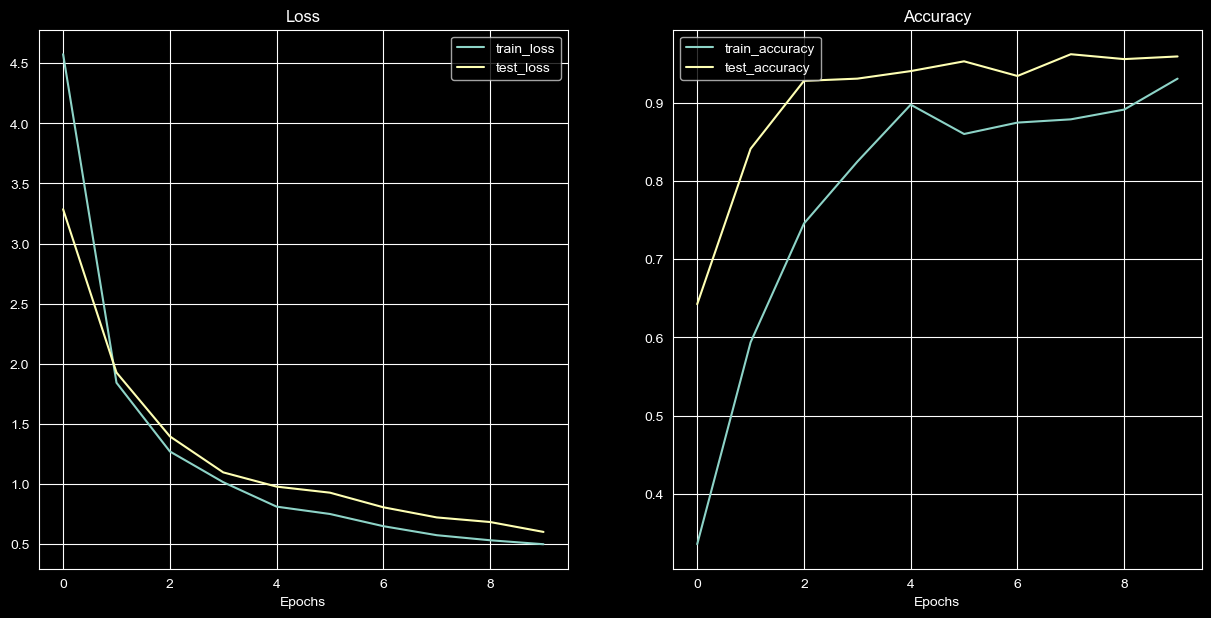

In [75]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetB2_results)

See here for what an ideal loss curve should look like: https://www.learnpytorch.io/04_pytorch_custom_datasets/#8-what-should-an-ideal-loss-curve-look-like

### 3.5 Saving EffNetB2 feature extracor

In [78]:
from going_modular import utils

# Save the model
utils.save_model(model=effnetB2_model,
                 target_dir="models",
                 model_name="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth


### 3.6 Inspecting the size of our EffNetB2 feature extractor

Why would it be important to consider the size of a saved model?

If we're deploying our model to be used on a mobile app/website, there may be limited compute resources.

So if our model file is too large, we may not be able to store/run it on our target device.

In [86]:
from pathlib import Path

# Get the model size in bytes and convert it to megabytes
pretrained_effnetB2_model_size = Path("models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size / (1024**2)
print(f"Pretrained EffNetB2 feature extractor model size: {pretrained_effnetB2_model_size:.2f}MB")

Pretrained EffNetB2 feature extractor model size: 35.22MB


### 3.7 Collecting EffNetB2 feature extractor stats

In [88]:
# Count number of parameters in EffNetB2
effnetB2_total_params = sum(torch.numel(param) for param in effnetB2_model.parameters())
effnetB2_total_params

9109994

In [91]:
# Create a dictionary with EffNetB2 statistics
effnetB2_stats = {"test_loss": effnetB2_results["test_loss"][-1],
                  "test_acc": effnetB2_results["test_acc"][-1],
                  "total_params": effnetB2_total_params,
                  "model_size (MB)": pretrained_effnetB2_model_size
}
effnetB2_stats

{'test_loss': 0.5988291501998901,
 'test_acc': 0.959659090909091,
 'total_params': 9109994,
 'model_size (MB)': 35.21587562561035}

## 4. Creating a ViT feature extractor

We're up to our second modelling experiment, repeating the steps for EffNetB2 but this time with a ViT feature extractor, see here for ideas: https://www.learnpytorch.io/08_pytorch_paper_replicating/#10-using-a-pretrained-vit-from-torchvisionmodels-on-the-same-dataset

In [101]:
# Check out the Vit heads layer
vit = torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [107]:
def create_vit_model(num_classes:int=3,
                     seed:int=42):
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

    for parameter in model.parameters():
        parameter.requires_grad = False

    # Update the classifier head
    set_seeds(seed)
    model.heads = nn.Sequential(
        nn.Linear(in_features=768, out_features=len(class_names)).to(device)
    )

    return model, transforms

In [108]:
vit_model, vit_transforms = create_vit_model()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [109]:
from torchinfo import summary

summary(model=vit_model,
        input_size=(1, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [100]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

In [113]:
# Setup dataloaders
from going_modular import data_setup
train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                       test_dir=test_dir,
                                                                                       train_transform=vit_transforms,
                                                                                       test_transform=vit_transforms,
                                                                                       batch_size=32)
len(train_dataloader_vit), len(test_dataloader_vit), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

### 4.2 Train ViT Feature Extractor

We're up to model experiment number two: a ViT feature extractor

In [ ]:
from going_modular import engine

optimizer = torch.optim.Adam(params=vit_model.parameters(), lr=0.001)

loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()
vit_results = engine.train(model=vit_model,
                                      train_dataloader=train_dataloader_vit,
                                      test_dataloader=test_dataloader_vit,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

### 4.3 Plot loss curves of ViT feature extractor

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(vit_results)

See here for what an ideal loss curve should look like: https://www.learnpytorch.io/04_pytorch_custom_datasets/#8-what-should-an-ideal-loss-curve-look-like

### 4.4 Saving Vit feature extractor

In [ ]:
# Save model
from going_modular import utils

utils.save_model(
    model=vit_model,
    target_dir="models",
    model_name="09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth"
)

### 4.5 Checking the size of ViT feature extractor

In [ ]:
pretrained_vit_model_size = Path("models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size / (1024**2)
print(f"Pretrained ViT feature extractor model size: {pretrained_effnetB2_model_size:.2f}MB")

In [ ]:
# Count number of parameters in EffNetB2
Vit_total_params = sum(torch.numel(param) for param in effnetB2_model.parameters())
effnetB2_total_params

### 4.6 Collecting ViT feature extractor stats

In [ ]:
# Create a dictionary with EffNetB2 statistics
vit_stats = {"test_loss": vit_results["test_loss"][-1],
             "test_acc": vit_results["test_acc"][-1],
             "total_params": Vit_total_params,
             "model_size (MB)": pretrained_vit_model_size
}
vit_stats

## 5. Make predictions ith our trained models and timing them

Our goal:
1. Performs well (95%+ test accuracy)
2. Fast (30+FPS)

To test criteria two:
1. Loop through test images
2. Time how long each model takes to make a prediction on the image

In [ ]:
from pathlib import Path
# Get all test data paths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

### 5.1 Creating  function to make across the test dataset

Steps to create `pred_and_store()`:
1. Create a function that takes a list of paths and a trained PyTorch and a series of transforms a list of target class names and a target device.
2. Create an empty list (can return a full list of all predictions later).
3. Loop through the target input paths (the rest of the steps will take place inside the loop).
4. Create an empty dictionary for each sample (prediction statistics will go in here).
5. We can get the sample path and ground truth class from the file path
6. Start the prediction timer
7. Open the image using `PIL.Image.open(path)`.
8. Transform the image to be usable with a given model.
9. Prepare the model for inference by sending to the target device and turning on `eval()`mode.
10. Turn on `torch.inference_mode()` and pass the target transformed image to the model and perform forward pass + calculate pred prob + pred class.
11. Add the pred prob + pred class to empty dictionary from step 4.
12. End the prediction timer started in step 6 and add the time to the prediction dictionary.
13. See oif the predicted class matches the ground truth class.
14. Append the updated prediction dictionary to the empty list we created in step 2.
15. Return the list of prediction dictionary.

In [ ]:
import pathlib
import torch

from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict

def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: torch.device | str = "cpu") -> List[Dict]:
    pred_list = []

    for path in tqdm(paths):
        pred_dict = {}
        pred_dict["image_path"] = path
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name

        start_time = timer()

        img = Image.open(path)
        transformed_img = transform(img).unsqueeze(0).to(device)

        model = model.to(device)
        model.eval()

        with torch.inference_mode():
            pred_logit = model(transformed_img)
            pred_prob = torch.softmax(pred_logit, dim=1)
            pred_lable = torch.argmax(pred_prob, dim=1)
            pred_class = class_names[pred_lable.cpu()]

            pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
            pred_dict["pred_class"] = pred_class
            end_time = timer()
            pred_dict["time_for_pred"] = round(end_time - start_time, 4)

        pred_dict["correct"] = class_name == pred_class

        pred_list.append(pred_dict)
    return pred_list

### 5.2 Making and timing predictions with EffNetB2

Let's test our 'pred and_store() function.
Two things to note:
1. Device - we're going to hardcode our predictions to happen on CPU (because you won't always be sure of having a GPU when you deploy your model
2. Transforms - we want to make sure each of the models are predicting on images that have been prepared with the appropriate transforms (e.g. EffNetB2 with effnetb2_transforms)

In [ ]:
# Make predictions test dataset with EffNetB2
effnetB2_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=effnetB2_model,
                                          transform=effnetB2_transforms,
                                          class_names=class_names,
                                          device=device)

In [ ]:
effnetB2_test_pred_dicts[:2]

In [ ]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd
effnetB2_test_pred_df = pd.DataFrame (effnetB2_test_pred_dicts)
effnetB2_test_pred_df.head()

In [ ]:
# Check number of correct predictions
effnetB2_test_pred_df.correct.value_counts()

In [ ]:
# Find the average time per prediction
effnetB2_average_time_per_pred = round(effnetB2_test_pred_df.time_for_pred.mean(), 4)
print(f"EffNetB2 average time per prediction: {effnetB2_average_time_per_pred}")

In [ ]:
# Add average time per prediction to ViT stats
effnetB2_stats["time_per_pred_cpu"] = effnetB2_average_time_per_pred
effnetB2_stats

### 5.3 Making and timing predictions with ViT

In [ ]:
# Make list of prediction dictionaries with ViT feature extractor model on test images
vit_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                     model=vit_model,
                                     transform=vit_transforms,
                                     class_names=class_names,
                                     device="cpu") # hardcode device to CPU because not sure if GPU available when we deploy

In [ ]:
# Check the first couple of ViT predictions
vit_test_pred_dicts[:2]

In [ ]:
# Turn vit_test_pred_dicts into a dataframe
import pandas as pd
vit_test_pred_df = pd.DataFrame (vit_test_pred_dicts)
vit_test_pred_df.head()

In [ ]:
# See how many correct
vit_test_pred_df.correct.value_counts()

In [ ]:
# Calculate average time per prediction for ViT model
vit_average_time_per_pred = round(vit_test_pred_df.time_for_pred.mean(), 4)
print(f"ViT average time per prediction: {vit_average_time_per_pred}")

In [ ]:
# Add average time per prediction to ViT stats
vit_stats["time_per_pred_cpu"] = vit_average_time_per_pred
vit_stats

## 6. Comparing model results, prediction times and size

In [ ]:
# Turn stat dictionaries into DataFrame
df = pd.DataFrame([effnetB2_stats, vit_stats])

# Add column for model names
df["model"] = ["EffNetB2", "ViT"]

# Convert accuracy to prcentage
df["test_acc"] = round(df["test_acc"]*100, 2)

df

Which model is better?
* `test_loss` (lower is better) - ViT
* `test_acc` (higher is better) - ViT
* `number_of_parameters` (generally lower is better*) - if a model has more parameters, it generally takes longer to compute.
* *sometimes models with higher parameters can still perform fast
* `model_size (MB)` - EffNetB2 (for our use case of deploying to a mobile device, generally lower is better)
* `time_pre_pred_cpu` - (lower is better, will be highly dependent on the hardware you're running on) - EffNefB2
Both models fail to achieve our goal of 30+FPS... however we could always just try and use EffNetB2 and see how it goes.

In [ ]:
# Compare ViT to EffNetB2 across different characteristics
pd.DataFrame(data=df.set_index("model").loc["ViT"] / df.set_index("model").loc["EffNetB2"],
             columns=["ViT to EffNetB2 ratios"]).T

# \# Progress updates

In [ ]:
from Progress.course_progress_func import update_progress, progress_pie_chart, monthly_progress, progress_report_print

update_progress(video_index=297, done=True)

In [ ]:
progress_report_print()

In [ ]:
progress_pie_chart()